Kaggle Categorical Feature Encoding Challenge II

Data contains binary features, ordinal features, nominal features, and cyclical features.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Load in the data

train = pd.read_csv('../input/cat-in-the-dat-ii/train.csv', index_col='id')
test = pd.read_csv('../input/cat-in-the-dat-ii/test.csv', index_col='id')
submission = pd.read_csv('../input/cat-in-the-dat-ii/sample_submission.csv')
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (600000, 24)
test shape:  (400000, 23)


In [3]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [4]:
#Create list of each type of feature

bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
time_cols = ['day', 'month']

In [5]:
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()

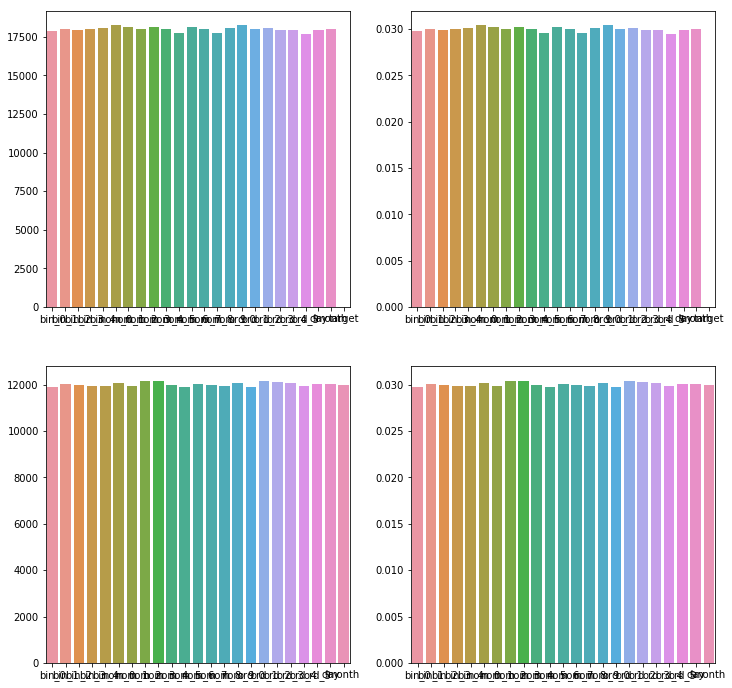

In [6]:
#Let's take a look at the missing data

fig, ax = plt.subplots (2, 2, figsize = (12,12))
sns.barplot(x=train.columns, y = train_missing, ax=ax[0,0])
sns.barplot(x=train.columns, y = train_missing/len(train), ax=ax[0,1])
sns.barplot(x= test.columns ,  y = test_missing, ax=ax[1,0])
sns.barplot(x = test.columns, y = test_missing/len(test), ax=ax[1,1])

We have around 3% missing data in every column

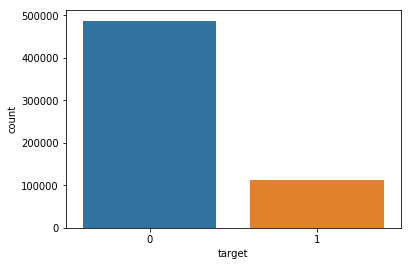

In [7]:
#Let's look at the distribution of the target
sns.countplot(train['target'])

The target is skewed, with around 80% having target 0.

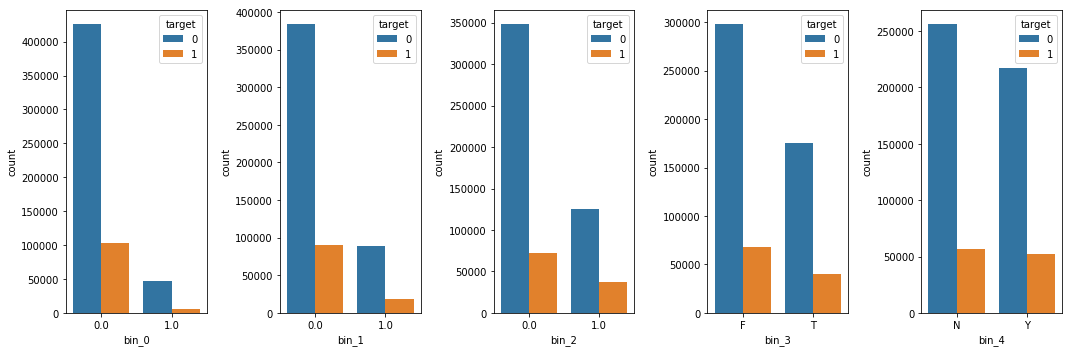

In [8]:
#Let's look at the binary features, and how they relate to target:

fig, ax = plt.subplots(1,5, figsize=(15, 5))

for i, col in enumerate(bin_cols):
    sns.countplot(col, hue = 'target', data= train, ax=ax[i])
plt.tight_layout()

All binary features have skew to 0 over 1, but not all the same percentage.

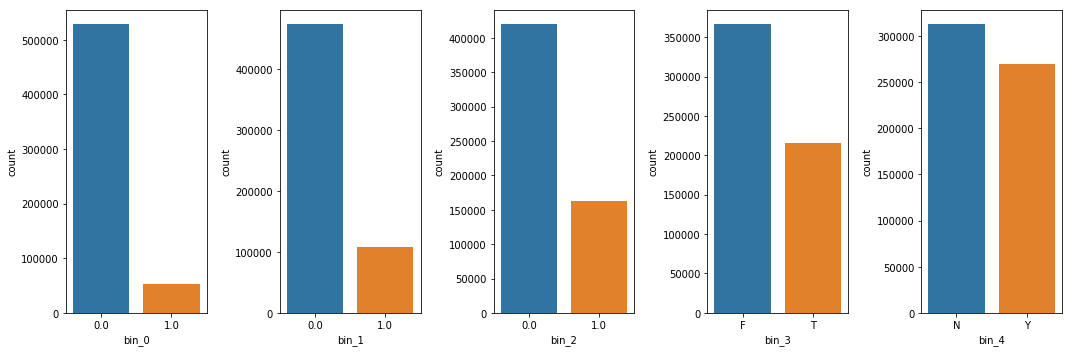

In [9]:
#And look at the binary features without splitting for target:

fig, ax = plt.subplots(1,5, figsize=(15, 5))

for i, col in enumerate(bin_cols):
    sns.countplot(train[col], ax=ax[i])
plt.tight_layout()

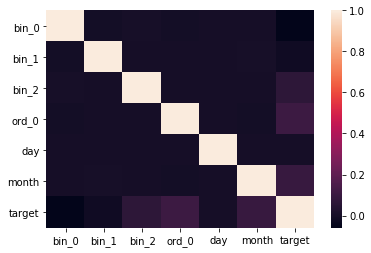

In [10]:
#Are any features correlated?

sns.heatmap(train.corr())

Small correlation between target and ord_0, as well as month. All other features have very low correlation.

In [11]:
#Let's look at all of the nominal features and their value counts:

for col in nom_cols:
    print(train[col].value_counts())
    print('')

Red      323286
Blue     205861
Green     52601
Name: nom_0, dtype: int64

Triangle     164190
Polygon      152563
Trapezoid    119438
Circle       104995
Square        26503
Star          14155
Name: nom_1, dtype: int64

Hamster    164897
Axolotl    152319
Lion       119504
Dog        104825
Cat         26276
Snake       14144
Name: nom_2, dtype: int64

India         164869
Costa Rica    151827
Russia        119840
Finland       104601
Canada         26425
China          14317
Name: nom_3, dtype: int64

Theremin    308621
Bassoon     196639
Oboe         49996
Piano        26709
Name: nom_4, dtype: int64

fc8fc7e56    977
360a16627    972
423976253    961
7917d446c    961
879c2ed83    960
            ... 
7335087fd      5
30019ce8a      3
d6bb2181a      1
b3ad70fcb      1
0385d0739      1
Name: nom_5, Length: 1220, dtype: int64

ea8c5e181    805
9fa481341    798
2b94ada45    792
32e9bd1ff    788
b88220966    781
            ... 
f0732a795      4
322548bed      3
b4b8de4b9      2
d6ea07

We have some high cardinality nominal features. Instead of one hot encoding, we can make them ordinal by their percentage of target = 1. It will not be perfect because many have low number of examples.

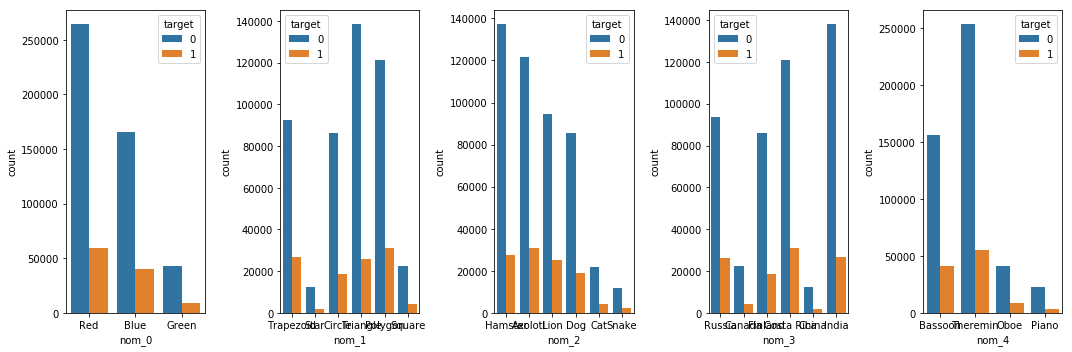

In [12]:
#Let's look at the nominal features and lower cardinality and how they split for target 0 or 1:

fig, ax = plt.subplots(1,5, figsize=(15, 5))

for i, col in enumerate(nom_cols[:5]):
    sns.countplot(col, hue = 'target', data=train, ax=ax[i])
plt.tight_layout()

In [13]:
#combine train and test data to do pre-processing once together:

data = pd.concat([train, test], sort=False).drop(columns='target')
data.shape

(1000000, 23)

In [14]:
#Look at the ratio of target 1:target 0 for the ordinal features:

for col in ord_cols:
    print((train[train['target']==1][col].value_counts()/train[train['target']==0][col].value_counts()).sort_values(ascending=False))
    print('')

3.0    0.315400
2.0    0.229291
1.0    0.165583
Name: ord_0, dtype: float64

Grandmaster    0.303218
Master         0.268473
Expert         0.234136
Contributor    0.209149
Novice         0.184868
Name: ord_1, dtype: float64

Lava Hot       0.409964
Boiling Hot    0.322756
Hot            0.258140
Warm           0.212715
Cold           0.179530
Freezing       0.152410
Name: ord_2, dtype: float64

o    0.448452
n    0.407228
m    0.362376
l    0.327869
k    0.296217
j    0.279536
i    0.243890
h    0.222617
g    0.207503
f    0.177906
e    0.156755
d    0.141654
c    0.128063
b    0.114692
a    0.100718
Name: ord_3, dtype: float64

Z    0.327677
Y    0.319641
X    0.305051
W    0.297959
V    0.292967
U    0.286899
T    0.281882
S    0.261669
R    0.261645
Q    0.254735
P    0.251569
O    0.239413
N    0.230168
M    0.226196
L    0.225592
J    0.212687
K    0.211288
I    0.198270
H    0.193837
G    0.192294
F    0.185718
E    0.176746
D    0.169893
C    0.161416
A    0.158356
B    0.15720

Makes sence, order is intuitive, so let's map to integers:

In [15]:
map_ord1 = {'Novice':0, 
            'Contributor':1, 
            'Expert':2, 
            'Master':3, 
            'Grandmaster':4}
data['ord_1'] = data['ord_1'].map(map_ord1)

map_ord2 = {'Freezing':0, 
            'Cold':1, 
            'Warm':2, 
            'Hot':3, 
            'Boiling Hot':4, 
            'Lava Hot':5}
data['ord_2'] = data['ord_2'].map(map_ord2)

In [16]:
#Can use ascii funciton

def ord3(x):
    return ord(x)-97
data['ord_3'] = data['ord_3'].map(ord3, na_action='ignore')

In [17]:
#Make sure it worked:
data['ord_3'].value_counts()

13.0    118514
0.0     108946
12.0     96352
2.0      94563
7.0      92718
14.0     75948
1.0      74251
4.0      64532
10.0     64318
8.0      58216
3.0      51186
5.0      49221
6.0      10383
9.0       6091
11.0      4792
Name: ord_3, dtype: int64

In [18]:
def ord4(x):
    num = ord(x) - 65
    if num == 0:
        num = 1
    elif num ==1:
        num = 0
    elif num == 9:
        num = 10
    elif num == 10:
        num = 9
    return num
data['ord_4'] = data['ord_4'].map(ord4, na_action='ignore')

In [19]:
#With a string of length 2, we can sort based on the ratio of target=1 : target=0, and encode that way:

ord5 = {key:(189-value) for value,key in enumerate((train[train['target']==1]['ord_5'].value_counts()/train[train['target']==0]['ord_5'].value_counts()).sort_values(ascending=False).index)} 
data['ord_5'] = data['ord_5'].map(ord5)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
bin_0    970205 non-null float64
bin_1    969959 non-null float64
bin_2    970098 non-null float64
bin_3    970035 non-null object
bin_4    970002 non-null object
nom_0    969686 non-null object
nom_1    969897 non-null object
nom_2    969786 non-null object
nom_3    969703 non-null object
nom_4    969972 non-null object
nom_5    970310 non-null object
nom_6    969857 non-null object
nom_7    969994 non-null object
nom_8    970289 non-null object
nom_9    969867 non-null object
ord_0    969819 non-null float64
ord_1    969792 non-null float64
ord_2    969820 non-null float64
ord_3    970031 non-null float64
ord_4    970137 non-null float64
ord_5    970240 non-null float64
day      970023 non-null float64
month    970028 non-null float64
dtypes: float64(11), object(12)
memory usage: 183.1+ MB


In [21]:
#Look at number of unique entries for nominal features:
for col in nom_cols:
    print(col, data[col].nunique())

nom_0 3
nom_1 6
nom_2 6
nom_3 6
nom_4 4
nom_5 1220
nom_6 1520
nom_7 222
nom_8 222
nom_9 2218


In [22]:
#And time features:
for col in time_cols:
    print(col, data[col].value_counts())
    print('')

day 3.0    189801
5.0    184141
6.0    161923
7.0    144151
1.0    141249
2.0    109316
4.0     39442
Name: day, dtype: int64

month 8.0     132517
3.0     117523
5.0     114802
12.0    113678
6.0     100779
7.0      89109
1.0      86765
11.0     85330
2.0      67628
9.0      34072
4.0      24183
10.0      3642
Name: month, dtype: int64



In [23]:
#Convert time features to unit circle x and y because they are cyclical:
for col in time_cols:
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/data[col].nunique())
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/data[col].nunique())
data = data.drop(columns=time_cols)

In [24]:
#Make binary features 0s and 1s
def bin3(x):
    if x == 'F':
        return 0
    elif x == 'T':
        return 1
    else:
        return x

data['bin_3'] = data['bin_3'].apply(lambda x: bin3(x))

In [25]:
def bin4(x):
    if x == 'N':
        return 0
    elif x == 'Y':
        return 1
    else:
        return x

data['bin_4'] = data['bin_4'].apply(lambda x: bin4(x))

In [26]:
#See if there is any hierarchy in this nominal features:
(train[train['target']==1]['nom_7'].value_counts()/train[train['target']==0]['nom_7'].value_counts()).sort_values(ascending=False)

b39008216    0.477273
230229e51    0.371327
942593b74    0.365546
3ef3018d3    0.362786
5ddc9a726    0.356387
               ...   
ac365406b    0.115875
598080a91    0.115202
b4eb50264    0.114508
ba9faf5b1    0.114186
8402256f6    0.113270
Name: nom_7, Length: 222, dtype: float64

Not clear. We can assign order based on how we did for the last ordinal feature. It won't be perfect, but it should improve over dropping the columns.

In [27]:
#Check to see if we have any entries in the test set that are not in the training set:
set(test['nom_6'])-set(train['nom_6'])

{'a885aacec'}

We have a lone entry in nominal feature 6 that is not in training set. We will assing it the average.

In [28]:
#Order the high cardinality nominal features:

nom5 = {key:(1220-value) for value,key in enumerate((train[train['target']==1]['nom_5'].value_counts()/train[train['target']==0]['nom_5'].value_counts()).sort_values(ascending=False).index)} 
data['nom_5'] = data['nom_5'].map(nom5)

nom6 = {key:(1520-value) for value,key in enumerate((train[train['target']==1]['nom_6'].value_counts()/train[train['target']==0]['nom_6'].value_counts()).sort_values(ascending=False).index)} 
data['nom_6'] = data['nom_6'].map(nom6)
data['nom_6'] = data['nom_6'].apply(lambda x: 1520/2 if x == 'a885aacec' else x)

nom7 = {key:(222-value) for value,key in enumerate((train[train['target']==1]['nom_7'].value_counts()/train[train['target']==0]['nom_7'].value_counts()).sort_values(ascending=False).index)} 
data['nom_7'] = data['nom_7'].map(nom7)

nom8 = {key:(222-value) for value,key in enumerate((train[train['target']==1]['nom_8'].value_counts()/train[train['target']==0]['nom_8'].value_counts()).sort_values(ascending=False).index)} 
data['nom_8'] = data['nom_8'].map(nom8)

nom9 = {key:(2218-value) for value,key in enumerate((train[train['target']==1]['nom_9'].value_counts()/train[train['target']==0]['nom_9'].value_counts()).sort_values(ascending=False).index)} 
data['nom_9'] = data['nom_9'].map(nom9)


In [29]:
data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,Bassoon,...,3.0,1.0,3.0,2.0,20.0,42.0,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,Theremin,...,3.0,4.0,2.0,4.0,23.0,145.0,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,Bassoon,...,3.0,NaN,0.0,13.0,15.0,118.0,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,NaN,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,Theremin,...,1.0,0.0,5.0,0.0,2.0,NaN,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,0.0,NaN,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,NaN,...,3.0,4.0,1.0,7.0,2.0,61.0,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00


In [30]:
#For the low cardinality nominal features, we can one-hot encode, including extra column for if null

data = pd.get_dummies(
    data,
    columns=nom_cols[:5],
    drop_first=True,
    dummy_na=True,
    sparse=True)
data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_3_nan,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,nom_4_nan
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,909.0,242.0,4.0,22.0,773.0,...,0,0,0,0,1,0,0,0,0,0
1,1.0,1.0,0.0,0.0,1.0,690.0,1089.0,26.0,139.0,591.0,...,0,0,0,0,0,1,0,0,1,0
2,0.0,1.0,0.0,0.0,0.0,539.0,286.0,218.0,95.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0.0,0.0,0.0,0.0,876.0,1138.0,44.0,175.0,2087.0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,NaN,0.0,1.0,0.0,196.0,263.0,129.0,NaN,1962.0,...,0,1,0,0,0,0,0,0,0,1


In [31]:
#Look at columns with null cells
data.isnull().sum()

bin_0               29795.0
bin_1               30041.0
bin_2               29902.0
bin_3               29965.0
bin_4               29998.0
nom_5               29690.0
nom_6               30144.0
nom_7               30006.0
nom_8               29711.0
nom_9               30133.0
ord_0               30181.0
ord_1               30208.0
ord_2               30180.0
ord_3               29969.0
ord_4               29863.0
ord_5               29760.0
day_sin             29977.0
day_cos             29977.0
month_sin           29972.0
month_cos           29972.0
nom_0_Green             0.0
nom_0_Red               0.0
nom_0_nan               0.0
nom_1_Polygon           0.0
nom_1_Square            0.0
nom_1_Star              0.0
nom_1_Trapezoid         0.0
nom_1_Triangle          0.0
nom_1_nan               0.0
nom_2_Cat               0.0
nom_2_Dog               0.0
nom_2_Hamster           0.0
nom_2_Lion              0.0
nom_2_Snake             0.0
nom_2_nan               0.0
nom_3_China         

In [32]:
#We need to impute. But we can also make extra features with 1 if data is missing in that column:

missing_data_columns = bin_cols + ord_cols + nom_cols[5:] + ['day_sin','month_sin']
for col in missing_data_columns:
    data[col+'_is_missing'] = data[col].isnull().astype(int)

In [33]:
#To impute for all columns, we will use the mean of the training data:

mean_imp_dic = {}
missing_data_columns = missing_data_columns + ['day_cos', 'month_cos']
for col in missing_data_columns:
    mean_imp_dic[col] = data[col][:600000].mean()
mean_imp_dic

#could possibly improve imputer?

{'bin_0': 0.0923010585700886,
 'bin_1': 0.18553188418497002,
 'bin_2': 0.2787035923514354,
 'bin_3': 0.370754622963439,
 'bin_4': 0.46328311736514804,
 'ord_0': 1.9482235195423165,
 'ord_1': 1.7194218149388532,
 'ord_2': 2.0830588134209735,
 'ord_3': 6.810774733543612,
 'ord_4': 12.293301492947583,
 'ord_5': 90.77979930858838,
 'nom_5': 610.7522319665007,
 'nom_6': 771.2109925086231,
 'nom_7': 113.15324477617582,
 'nom_8': 113.6072787228744,
 'nom_9': 1115.426807829848,
 'day_sin': -0.02517469905991493,
 'month_sin': 0.06041231356722278,
 'day_cos': 0.06351955496895055,
 'month_cos': -0.05868436797517374}

In [34]:
#Fill NaN in train and test (data) with that mean:
for col in missing_data_columns:
    data[col].fillna(mean_imp_dic[col], inplace = True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 63 columns):
bin_0                   -1000000 non-null float64
bin_1                   -1000000 non-null float64
bin_2                   -1000000 non-null float64
bin_3                   -1000000 non-null float64
bin_4                   -1000000 non-null float64
nom_5                   -1000000 non-null float64
nom_6                   -1000000 non-null float64
nom_7                   -1000000 non-null float64
nom_8                   -1000000 non-null float64
nom_9                   -1000000 non-null float64
ord_0                   -1000000 non-null float64
ord_1                   -1000000 non-null float64
ord_2                   -1000000 non-null float64
ord_3                   -1000000 non-null float64
ord_4                   -1000000 non-null float64
ord_5                   -1000000 non-null float64
day_sin                 -1000000 non-null float64
day_cos                 -1000000 non-n

No more missing data! And all features are numerical. We can begin building a model.
First, we will use a min-max scaler, which will improve if we use certain models:

In [36]:
from sklearn import preprocessing

data_values = data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data_values)

data = pd.DataFrame(data_scaled)

Let's explore a few different models. We will try logistic regression, random forest, xgboost, and catboost:

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(data[:600000], train['target'],
                                                  test_size=0.025, random_state=1)

print("Logistic Regressor")
print("")
logmodel = LogisticRegression(solver = 'saga', verbose = 1) #Documentation says 'saga' solver is good for big data sets
logmodel.fit(X_train,y_train)
logpredictions = logmodel.predict(X_val)

print("Random Forest Regressor")
print("")
forestmodel = RandomForestRegressor(n_estimators=50, verbose = 2)
forestmodel.fit(X_train,y_train)
forestpredictions = forestmodel.predict(X_val)

print("XBG Regressor")
print("")
xgbmodel = XGBRegressor(n_estimators=30, learning_rate=0.001, random_state=0, verbosity = 2)
xgbmodel.fit(X_train,y_train)
xgbpredictions = xgbmodel.predict(X_val)


categorical_features_indices = []
catmodel=CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, subsample=0.9,
                              eval_metric='AUC', metric_period=20, allow_writing_files=False)

catmodel.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val))
catpredictions = catmodel.predict(X_val)

Logistic Regressor



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 19 seconds
Random Forest Regressor

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


XBG Regressor

[20:08:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:08:57] INFO: 

In [38]:
print("log ROC_auc: ", roc_auc_score(y_val,logpredictions))
print("forest ROC_auc: ", roc_auc_score(y_val, forestpredictions))
print("xgb ROC_auc: ", roc_auc_score(y_val, xgbpredictions))
print("cat ROC_auc: ", roc_auc_score(y_val, catpredictions))

log ROC_auc:  0.5935943397155369
forest ROC_auc:  0.7562555418167735
xgb ROC_auc:  0.7173483247829342
cat ROC_auc:  0.7975764823466027


CatBoostRegressor performed the best, so we will use that to predict on test set to submit:

In [39]:
cat_test_predictions = catmodel.predict(data[600000:])

In [40]:
submission['target'] = cat_test_predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,600000,0.119019
1,600001,0.291614
2,600002,0.172049
3,600003,0.170678
4,600004,0.105016
